# Data exploration

In [1]:
import os

In [2]:
os.environ['NOSWEAR2_DATA_ROOT'] = '/home/nemo/Code/deepcyber/noswear-data'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import noswear2.dataset
from sklearn.model_selection import train_test_split

In [4]:
providers = noswear2.dataset.DEFAULT_PROVIDERS

In [5]:
providers['crawler'] = {
    'path': os.path.join(
        noswear2.dataset.DATA_ROOT,
        'crawler/seg/',
    ),
    'format': 'wav',
}

In [6]:
ds = noswear2.dataset.SwearDataset(
    providers=providers,
    good_word_path=os.path.join(noswear2.dataset.DATA_ROOT, 'good_words.txt'),
    bad_word_path=os.path.join(noswear2.dataset.DATA_ROOT, 'bad_words.txt'),
)

In [7]:
X, y = ds.load()

In [8]:
words, files, provider = zip(*X)

In [9]:
df = pd.DataFrame({
    'word': words,
    'file': files,
    'provider': provider,
    'swear': y,
})

In [10]:
df.sample(5)

,word,file,provider,swear
300,asshole,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,True
15,duck,/home/nemo/Code/deepcyber/noswear-data/meriamw...,meriamwebster,False
118,it,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,False
322,ass,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,True
231,fuck,/home/nemo/Code/deepcyber/noswear-data/meriamw...,meriamwebster,True


In [11]:
df.swear.mean()

0.5614035087719298

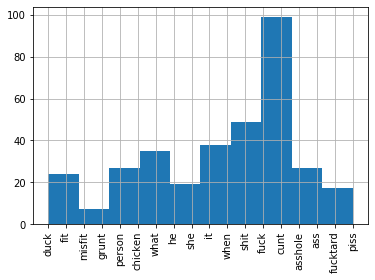

In [12]:
df.word.hist(xrot=90);

# Build precise datasets

In [72]:
def convert_mp3_to_wav(path):
    path_wav = path[:-3] + 'wav'
    if not os.path.exists(path_wav):
        os.system('sox {} -r 16000 -b 16 -c 1 {}'.format(path, path_wav))
    return path_wav

In [73]:
def resample_wav(path):
    """downsample to 16kHz 16 bit and re-mix channels to mono"""
    path_wav = path[:-3] + '16k.wav'
    os.system('sox {} -r 16000 -b 16 -c 1 {}'.format(path, path_wav))
    return path_wav

In [141]:
def build_dataset_from_df(df_train, df_test, ds_directory, overwrite=False):
    """Sort files into a mycroft-precise compatible training set using data
    from the data frame. Relevant columns in the data frame are 
    - swear (bool): is swear (=wake) word
    - file (str): path to .wav or .mp3 file (mp3 will be converted using SOX)
    """
    assert 'swear' in df_train.columns
    assert 'swear' in df_test.columns
    from shutil import copy, move
    
    if os.path.exists(ds_directory) and not overwrite:
        print('Directory already exists. Skipping.')
        return
    else:
        os.makedirs(ds_directory, exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'not-wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'test', 'wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'test', 'not-wake-word'), exist_ok=True)
    
    for is_train, df in zip((True, False), (df_train, df_test)):
        for idx, path, word, is_swear in df[['file', 'word', 'swear']].itertuples():
            #print(f'{path} swear={is_swear} train={is_train}')
            if path.endswith('.mp3'):
                path = convert_mp3_to_wav(path)
                op = move
            else:
                path = resample_wav(path)
                op = copy

            subdir = '.' if is_train else 'test'
            class_dir = 'wake-word' if is_swear else 'not-wake-word'
            name = f'{word}.{idx}.wav'
            target_dir = os.path.join(ds_directory, subdir, class_dir)

            op(path, os.path.join(target_dir, name))

In [117]:
def df_train_test_split(df):
    train_idx, test_idx = train_test_split(df.index, random_state=42, stratify=df.word)
    return df.loc[train_idx], df.loc[test_idx]

## "fuck" and all others in validation

In [118]:
simple_mask = df.word.isin(['fuck'])
df_simple = df[simple_mask]

df_simple_train, df_simple_test = df_train_test_split(df_simple)

# append all non-fuck samples to the test set
df_simple_test = df_simple_test.append(df[~simple_mask])

In [119]:
df_simple_train.swear.mean(), df_simple_test.swear.mean()

(1.0, 0.4827586206896552)

In [120]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(
        noswear2.dataset.DATA_ROOT, 
        'datasets', 
        'fuck_only'), 
    overwrite=True)

True 225 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_1.wav
True 226 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_17.wav
True 266 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_34.16k.wav
True 239 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_19.16k.16k.16k.wav
True 214 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_16.wav
True 217 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_14.wav
True 203 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_22.wav
True 218 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_2.wav
True 233 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_40.16k.wav
True 267 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_23.16k.16k.wav
True 207 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_9.wav
True 268 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_1.16k.16k.wav
True 258 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_8.16k.16k.16k.wav


False 38 /home/nemo/Code/deepcyber/noswear-data/forvo/download/person_2.wav
False 39 /home/nemo/Code/deepcyber/noswear-data/forvo/download/person_7.wav
False 40 /home/nemo/Code/deepcyber/noswear-data/forvo/download/person_6.wav
False 41 /home/nemo/Code/deepcyber/noswear-data/forvo/download/person_4.wav
False 42 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/chicken_0.wav
False 43 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_4.wav
False 44 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_2.wav
False 45 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_5.wav
False 46 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_8.wav
False 47 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_14.wav
False 48 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_1.wav
False 49 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_12.wav
False 50 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_11.wav

False 151 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/shit_0.wav
False 152 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/shit_1.wav
False 153 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_2.wav
False 154 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_6.wav
False 155 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_20.wav
False 156 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_21.wav
False 157 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_22.wav
False 158 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_16.wav
False 159 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_5.wav
False 160 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_1.wav
False 161 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_23.wav
False 162 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_4.wav
False 163 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_11.wav
False 164 /home/n

False 331 /home/nemo/Code/deepcyber/noswear-data/forvo/download/piss_3.wav
False 332 /home/nemo/Code/deepcyber/noswear-data/forvo/download/piss_2.wav
False 333 /home/nemo/Code/deepcyber/noswear-data/forvo/download/piss_7.wav
False 334 /home/nemo/Code/deepcyber/noswear-data/forvo/download/piss_4.wav
False 335 /home/nemo/Code/deepcyber/noswear-data/forvo/download/piss_1.wav
False 336 /home/nemo/Code/deepcyber/noswear-data/forvo/download/piss_5.wav
False 337 /home/nemo/Code/deepcyber/noswear-data/forvo/download/piss_6.wav
False 338 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/piss_01.16k.16k.16k.wav
False 339 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/piss_01.16k.16k.16k.16k.wav
False 340 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/piss_01.16k.16k.wav
False 341 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/piss_01.16k.wav


## "fuck" and non-swear words in train

In [121]:
simple_mask = df.word.isin(['fuck']) | ~df.swear
df_simple = df[simple_mask]
df_simple_train, df_simple_test = df_train_test_split(df_simple)

In [122]:
df_simple_train.swear.mean(), df_simple_test.swear.mean()

(0.3212121212121212, 0.3090909090909091)

In [123]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(
        noswear2.dataset.DATA_ROOT, 
        'datasets', 
        'fuck_and_non_swear'), 
    overwrite=True)

True 149 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/when_01.16k.wav
True 249 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_8.16k.wav
True 10 /home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_3.wav
True 253 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_1.16k.wav
True 223 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_19.wav
True 237 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_34.16k.16k.wav
True 216 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_18.wav
True 105 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/she_0.wav
True 147 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/when_01.16k.16k.wav
True 74 /home/nemo/Code/deepcyber/noswear-data/forvo/download/what_7.wav
True 17 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/duck_01.16k.wav
True 203 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_22.wav
True 134 /home/nemo/Code/deepcyber/noswear-data/forvo/downloa

True 225 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_1.wav
True 148 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/when_01.16k.16k.16k.16k.wav
True 3 /home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_5.wav
True 140 /home/nemo/Code/deepcyber/noswear-data/forvo/download/when_2.wav
True 240 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_30.16k.wav
True 87 /home/nemo/Code/deepcyber/noswear-data/forvo/download/what_14.wav
True 6 /home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_6.wav
True 86 /home/nemo/Code/deepcyber/noswear-data/forvo/download/what_27.wav
True 26 /home/nemo/Code/deepcyber/noswear-data/forvo/download/misfit_1.wav
True 57 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_9.wav
True 108 /home/nemo/Code/deepcyber/noswear-data/forvo/download/she_1.wav
True 241 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_37.16k.16k.16k.wav
True 255 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_19.16k.wav
T

## "fuck" and non-swear words in train (balanced)

In [124]:
fuck_mask = df.word.isin(['fuck'])

In [125]:
# calculate smallest non-fuck word count and use it to 
# sample as many samples as there are fuck samples
n = int(np.ceil(
    fuck_mask.sum() / df[~df.swear].word.nunique()
))

In [126]:
nonfuck_idcs = df[(~df.swear)].groupby('word').apply(
    lambda x: x.sample(n) if len(x) > n else x
).index.levels[1]

In [127]:
# make sure nonfuck and fuck samples are approx. balanced
assert abs(len(nonfuck_idcs) - fuck_mask.sum()) < 5

In [128]:
df_simple = df[fuck_mask]
df_simple = df_simple.append(df.loc[nonfuck_idcs])

In [129]:
df_simple_train, df_simple_test = df_train_test_split(df_simple)

In [130]:
df_simple_train.swear.mean(), df_simple_test.swear.mean()

(0.5096153846153846, 0.4857142857142857)

In [131]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(
        noswear2.dataset.DATA_ROOT, 
        'datasets', 
        'fuck_and_non_swear_balanced'
    ), 
    overwrite=True)

True 37 /home/nemo/Code/deepcyber/noswear-data/forvo/download/person_8.wav
True 143 /home/nemo/Code/deepcyber/noswear-data/forvo/download/when_1.wav
True 233 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_40.16k.wav
True 4 /home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_1.wav
True 2 /home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_12.wav
True 205 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_3.wav
True 202 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_23.wav
True 268 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_1.16k.16k.wav
True 32 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/person_0.wav
True 232 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_34.16k.16k.16k.wav
True 259 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_23.16k.16k.16k.wav
True 260 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_3.16k.16k.16k.wav
True 212 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_4.wav
T

False 210 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_8.wav
False 57 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_9.wav
False 100 /home/nemo/Code/deepcyber/noswear-data/forvo/download/he_8.wav
False 256 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_19.16k.16k.wav
False 12 /home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_7.wav
False 103 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/she_2.wav
False 251 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_26.16k.wav
False 258 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_8.16k.16k.16k.wav
False 26 /home/nemo/Code/deepcyber/noswear-data/forvo/download/misfit_1.wav
False 14 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/duck_01.16k.16k.wav
False 242 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_26.16k.16k.wav
False 112 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/it_0.wav
False 220 /home/nemo/Code/deepcyber/noswear-data/forvo/downloa

## "fuck" + "shit" and non-swear words in train (balanced)

In [132]:
fuck_mask = df.word.isin(['fuck', 'shit'])

In [133]:
# calculate smallest non-fuck word count and use it to 
# sample as many samples as there are fuck samples
n = int(np.ceil(
    fuck_mask.sum() / df[~df.swear].word.nunique()
))

In [134]:
nonfuck_idcs = df[(~df.swear)].groupby('word').apply(
    lambda x: x.sample(n) if len(x) > n else x
).index.levels[1]

In [135]:
len(nonfuck_idcs), fuck_mask.sum()

(98, 119)

In [136]:
# make sure nonfuck and fuck samples are approx. balanced
assert abs(len(nonfuck_idcs) - fuck_mask.sum()) < 30

In [137]:
df_simple = df[fuck_mask]
df_simple = df_simple.append(df.loc[nonfuck_idcs])

In [138]:
df_simple_train, df_simple_test = df_train_test_split(df_simple)

In [139]:
df_simple_train.swear.mean(), df_simple_test.swear.mean()

(0.5493827160493827, 0.5454545454545454)

In [140]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(
        noswear2.dataset.DATA_ROOT, 
        'datasets', 
        'fuck+shit_and_non_swear_balanced'
    ), 
    overwrite=True)

True 218 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_2.wav
True 189 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/shit_7.16k.16k.wav
True 246 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_8.16k.16k.wav
True 143 /home/nemo/Code/deepcyber/noswear-data/forvo/download/when_1.wav
True 190 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/shit_11.16k.16k.wav
True 182 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/shit_03.16k.wav
True 248 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_23.16k.wav
True 200 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/fuck_1.wav
True 12 /home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_7.wav
True 94 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/he_1.wav
True 97 /home/nemo/Code/deepcyber/noswear-data/forvo/download/he_5.wav
True 229 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/fuck_01.16k.wav
True 155 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_20.wa

True 61 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/what_1.wav
True 1 /home/nemo/Code/deepcyber/noswear-data/dictcc/download/duck_0.wav
True 265 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/fuck_3.16k.wav
True 50 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_11.wav
True 43 /home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_4.wav
True 157 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_22.wav
True 206 /home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_24.wav
True 76 /home/nemo/Code/deepcyber/noswear-data/forvo/download/what_4.wav
True 192 /home/nemo/Code/deepcyber/noswear-data/crawler/seg/shit_9.16k.wav
True 163 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_11.wav
True 168 /home/nemo/Code/deepcyber/noswear-data/forvo/download/shit_24.wav
True 17 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/duck_01.16k.wav
True 178 /home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/shit_01.16k.16k.wav
